# Space Partitioning

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import cm
import copy
import itertools
import nlopt

In [3]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [107]:
def fun(x):
    '''ring'''
    r = np.sqrt(np.sum(np.square(np.asarray(x) - 12), axis=0))
    return np.exp(-(r - 10)**2/30)

In [361]:
def fun(x):
    '''eggbox'''
    return (2 + np.cos(x[0]/2) * np.cos(x[1]/2))**5

In [109]:
def fun(x):
    '''gaussian'''
    return np.exp(-((x[0] - 10)**2 + (x[1] - 15)**2)/100)

In [110]:
def phi(d): 
    # Using the above nested radical formula for g=phi_d 
    # or you could just hard-code it. 
    # phi(1) = 1.61803398874989484820458683436563 
    # phi(2) = 1.32471795724474602596090885447809 

    x=2.0
    for i in range(10): 
        x = pow(1+x,1/(d+1)) 
    return x


def quasi_rand(ndim, nsamples):

    ''' from http://extremelearning.com.au/unreasonable-effectiveness-of-quasirandom-sequences/
    
    ndim : number of dimesnions
    nsamples : number of samples
    
    '''


    g = phi(ndim) 
    alpha = np.zeros(ndim) 
    for j in range(ndim): 
        alpha[j] = pow(1 / g, j+1) % 1 
        
    sample = np.zeros((ndim, nsamples)) 

    # This number can be any real number. 
    # Common default setting is typically seed=0
    # But seed = 0.5 is generally better. 

    seed = 0.5

    for i in range(nsamples): 
        sample[:,i] = (seed + alpha * (i + 1)) % 1
        
    return sample

In [111]:
bounds = np.array([[0, 36.], [3, 30.]])

In [112]:
N = 300
xx, yy = np.meshgrid(np.linspace(*bounds[0],N), np.linspace(*bounds[1],N))

In [113]:
f = fun([xx, yy])

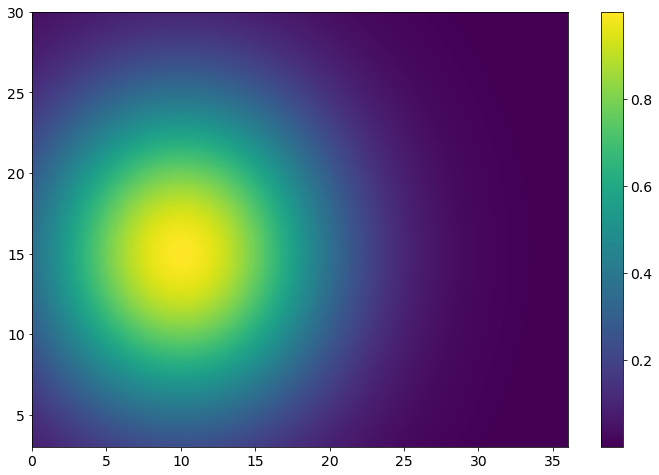

In [114]:
pc = plt.pcolormesh(xx, yy, f)
plt.colorbar(pc)

## Generate samples

In [115]:
n_samples = 1000
#x = np.random.rand(2, n_samples)

x = quasi_rand(2, n_samples)


x[0] = x[0] * (bounds[0][1] - bounds[0][0]) + bounds[0][0]
x[1] = x[1] * (bounds[1][1] - bounds[1][0]) + bounds[1][0]
z = fun(x)

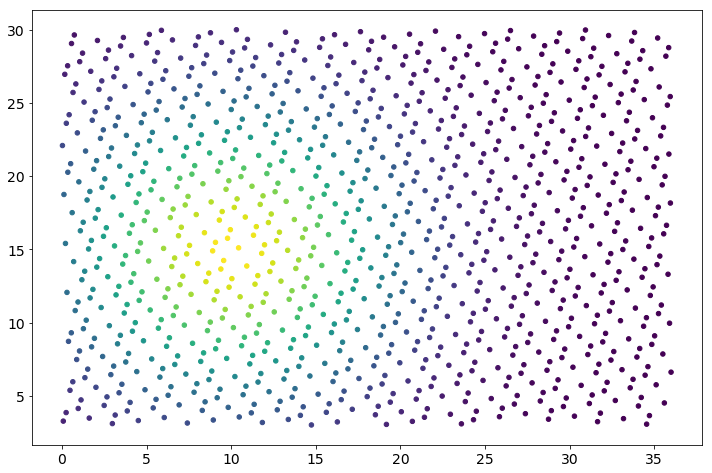

In [116]:
plt.scatter(x[0],x[1],c=z, s=20)

## Metric / Cost function

In [315]:
def metric(x, z):
    if len(z) == 0:
        return 1000
    #return np.var(z) * len(z)
    mean = np.average(x, axis=1, weights=z)
    diff = bounds[:,1] - bounds[:,0]
    return np.sum(z * np.sum(((x - mean[:, np.newaxis])/diff[:, np.newaxis])**2, axis=0))
    #return np.var(z) * np.sum(z) 
    #return np.var(z) * len(z) #+ np.sum(np.sum((x - mean[:, np.newaxis])**2, axis=0))

In [118]:
metric(x,z)

78.46351944196951

In [119]:
def weighted_avg_and_var(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    if len(values) == 0:
        return (0, 0)
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, variance)

In [259]:
def between_class_var(x, z, t):
    '''
    x :  sample
    z : weights
    t : threshold
    
    https://medium.com/@hbyacademic/otsu-thresholding-4337710dc519
    '''

    mu_tot, var_tot = weighted_avg_and_var(x, z)
    
    mask = x < t
    
    mu_1, var_1 = weighted_avg_and_var(x[mask], z[mask])
    mu_2, var_2 = weighted_avg_and_var(x[~mask], z[~mask])
        
    return var_tot - 1/np.sum(z) * (np.sum(z[mask]) * var_1 + np.sum(z[~mask]) * var_2)

In [254]:
def between_class_var(x, z, t):
    '''
    x :  sample
    z : weights
    t : threshold
    
    https://medium.com/@hbyacademic/otsu-thresholding-4337710dc519
    '''
    mask = x < t
    
    
    mu_1, var_1 = weighted_avg_and_var(x[mask], z[mask])
    mu_2, var_2 = weighted_avg_and_var(x[~mask], z[~mask])
        
    return np.sum(z[mask]) * np.sum(z[~mask]) * (mu_1 - mu_2)**2

In [267]:
def between_class_var(x, z, t):
    '''
    x :  sample
    z : weights
    t : threshold
    
    https://medium.com/@hbyacademic/otsu-thresholding-4337710dc519
    '''
    mask = x < t
    
    
    var_1 = np.var(z[mask])
    var_2 = np.var(z[~mask])
    
    return np.sum(z[mask]) * var_1 + np.sum(z[~mask]) * var_2
    
    #mu_1, var_1 = weighted_avg_and_var(z[mask], z[mask])
    #mu_2, var_2 = weighted_avg_and_var(z[~mask], z[~mask])
        
    #return np.sum(z[mask]) * np.sum(z[~mask]) * (mu_1 - mu_2)**2

In [318]:
dim = 10

x_cuts = np.linspace(*bounds[dim], 300)
vals = []
for x_cut in x_cuts:
    
    #vals.append(between_class_var(x[dim], z, x_cut))
    
    mask = x[dim] < x_cut
    vals.append((metric(x[:,mask],z[mask]) + metric(x[:,~mask],z[~mask])))

x_cuts[np.argmin(vals)]

2885.8033443278405

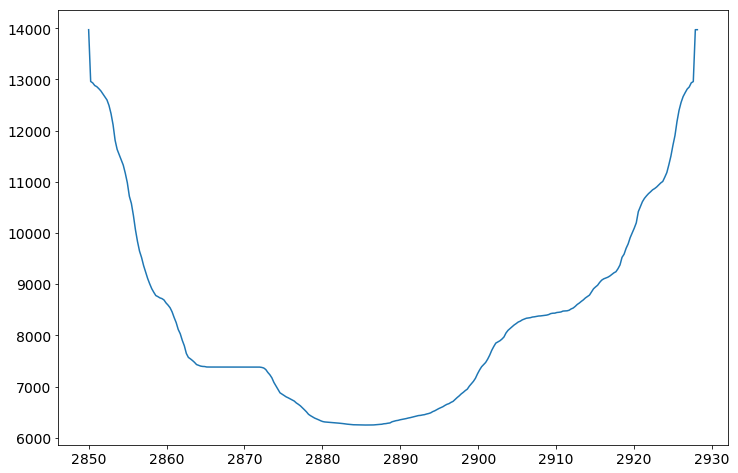

In [319]:
plt.plot(x_cuts, vals)

## Binary Tree

In [133]:
class Node():
    def __init__(self, dim=0, cut=0.5, terminal=False):
        self._dim = None
        self._cut = None
        self.val = None
        
        self.terminal = terminal
        self.left = None
        self.right = None
        
        self.cut = cut
        self.dim = dim
        
    def __repr__(self):
        return str(self.rep)
        
    @property
    def rep(self):
        if self.terminal:
            return 'terminal'
        return [self.dim, self.cut, self.left.rep, self.right.rep]
    
    @property
    def cut(self):
        return self._cut
    
    @cut.setter
    def cut(self, cut):
        if not self.terminal:
            self.invalidate()
            self._cut = cut

    @property
    def dim(self):
        return self._dim
        
    @dim.setter
    def dim(self, dim):
        if not self.terminal:
            self.invalidate()
            self._dim = dim
            
    def invalidate(self):
        if self.terminal:
            self.val = None
        else:
            if self.left is not None:
                self.left.invalidate()
            if self.right is not None:
                self.right.invalidate()
            
    @property
    def cuts(self):
        '''get flat array of cuts
        '''
        if self.terminal:
            return []
        return [self.cut] + self.left.cuts + self.right.cuts
    
    def get_terminal_nodes(self):
        if self.terminal:
            return [self]
        return self.left.get_terminal_nodes() + self.right.get_terminal_nodes()     
        
    def set_vals(self, vals, idx=0):
        if self.terminal:
            return idx
        self.cut = vals[idx]
        idx += 1
        idx = self.left.set_vals(vals, idx) 
        idx = self.right.set_vals(vals, idx) 
        return idx
        
    def cut_value(self, parent_bounds):
        return (1 - self.cut) * parent_bounds[self.dim, 0] + self.cut * parent_bounds[self.dim, 1]
        
    def eval(self, x, z, parent_bounds):
        if self.terminal:
            if self.val is None:
                mask = np.ones_like(z).astype(np.bool)
                for dim in range(len(parent_bounds)):
                    mask &= (x[dim] >= parent_bounds[dim][0]) & (x[dim] < parent_bounds[dim][1])
                self.val = metric(x[:, mask], z[mask])
            return self.val
        else:
            bounds = self.bounds(parent_bounds)
            return self.left.eval(x, z, bounds[0]) + self.right.eval(x, z, bounds[1])
        
    def bounds(self, parent_bounds):
        if self.terminal:
            return parent_bounds
        bounds = [copy.deepcopy(parent_bounds), copy.deepcopy(parent_bounds)]
        cut = self.cut_value(parent_bounds)
        bounds[0][self.dim, 1] = cut
        bounds[1][self.dim, 0] = cut
        return bounds
        
    def recursive_bounds(self, parent_bounds):
        if self.terminal:
            return parent_bounds
        else:
            bounds = self.bounds(parent_bounds)
            return [self.left.recursive_bounds(bounds[0]), self.right.recursive_bounds(bounds[1])]

In [134]:
def make_tree(recursion_depth=0):
    if np.random.rand() > 2 / (recursion_depth + 1):
        return Node(terminal=True)
    node = Node(np.random.randint(0, len(bounds)), (np.random.rand() + np.random.rand())/2)
    node.left =  make_tree(recursion_depth+1)
    node.right =  make_tree(recursion_depth+1)
    return node

In [135]:
def make_nice_tree(max_depth, recursion_depth=0, dim=0):
    if recursion_depth > max_depth:
        return Node(terminal=True)
    node = Node(dim, 0.5)
    node.left =  make_nice_tree(max_depth, recursion_depth+1, (dim+1)%2)
    node.right =  make_nice_tree(max_depth, recursion_depth+1, (dim+1)%2)
    return node

In [136]:
def tree_from_rep(rep):
    if rep is None:
        return Node(terminal=True)
    node = Node(rep[0], rep[1])
    node.left = tree_from_rep(rep[2])
    node.right = tree_from_rep(rep[3])
    return node

In [137]:
def flatten(L):
    return [L] if not isinstance(L, list) else [x for X in L for x in flatten(X)]

In [165]:
def plot_tree(tree, axis, color='k', dims=[0,1]):
    boxes = flatten(tree.recursive_bounds(bounds))
    #color=cm.jet(np.linspace(0,1,len(boxes)))
    for i, box in enumerate(boxes):
        r = patches.Rectangle(box[dims,0], box[dims[0],1] - box[dims[0],0], box[dims[1],1] - box[dims[1],0], fill=None, color=color) #alpha=0.0, facecolor=color[i], edgecolor='k', linewidth=2.0)
        axis.add_patch(r)
    
    axis.set_xlim(bounds[dims[0]])
    axis.set_ylim(bounds[dims[1]])

In [139]:
tree = make_tree(0)

In [141]:
def combine(rep1, rep2):
    if rep1 is None:
        return None
    else:
        w = np.random.rand()
        return [rep1[0], (1 - w) * rep1[1] + w * rep2[1], combine(rep1[2], rep2[2]), combine(rep1[3], rep2[3])]

## recursive splitting

Building a tree doing a recursive splitting using the cut with the globally best performance over all dimensions

In [343]:
tree = Node(terminal=True)

dims = [6, 7, 10]
cuts = np.linspace(0, 1, 101)[1:-1]

In [359]:
for iter in range(3):

    nodes = tree.get_terminal_nodes()

    node_idx = 0
    node_dim = 0
    node_cut = 0
    best_val = np.inf


    for i, node in enumerate(nodes):
        #vals.append({})

        node.terminal = False
        node.left = Node(terminal=True)
        node.right = Node(terminal=True)

        for dim in dims:
            #vals[-1][dim] = []
            node.dim = dim
            for cut in cuts:
                node.cut = cut
                val = tree.eval(x, z, bounds)

                if val < best_val:
                    best_val = val
                    node_idx = i
                    node_dim = dim
                    node_cut = cut

        node.terminal = True
        node.left = None
        node.right = None

    print(iter, node_dim, node_cut, best_val)

    # set split at best node / value
    nodes[node_idx].terminal = False
    nodes[node_idx].left = Node(terminal=True)
    nodes[node_idx].right = Node(terminal=True)
    nodes[node_idx].dim = node_dim
    nodes[node_idx].cut = node_cut

0 10 0.5 3078.609976663928
1 10 0.46 3055.2730183300782
2 7 0.59 3035.495122710372


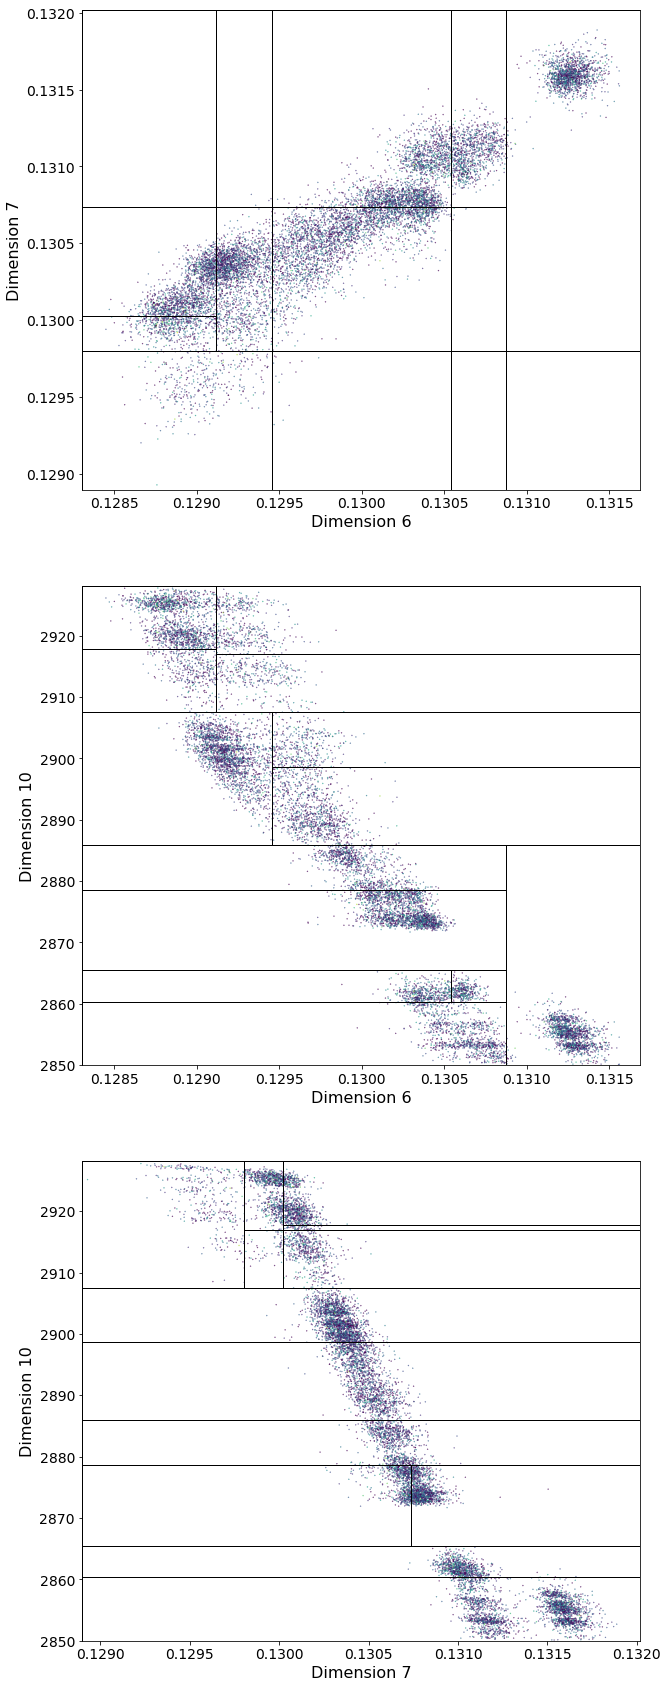

In [360]:
#pc = plt.pcolormesh(xx, yy, f, cmap='Spectral_r')
#plt.colorbar(pc)

fig, ax = plt.subplots(3, 1, figsize=(10,30))


for i, plot_dims in enumerate([[6,7], [6,10], [7,10]]):

    ax[i].scatter(x[plot_dims[0]],x[plot_dims[1]],c=np.log(z), s=0.1)
    plot_tree(tree, ax[i], color='k', dims=plot_dims)
    ax[i].set_xlabel(f'Dimension {plot_dims[0]}')
    ax[i].set_ylabel(f'Dimension {plot_dims[1]}')


plt.savefig('dim_6_7_10_partitioning.png')

In [249]:
cuts

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

## global opt
maybe easier to do recursive binary opt

In [30]:
tree = make_tree(0)
tree

[1, 0.5283474291747494, [1, 0.3036317703255227, [0, 0.54520478617487, None, [1, 0.9789003766234058, [1, 0.3636813491159786, None, None], None]], None], [0, 0.4180714053155326, [0, 0.3882441590165477, [1, 0.520348536245437, None, None], None], [0, 0.025214250859556808, [0, 0.1565199890110956, [1, 0.5890288974042106, None, None], [1, 0.6812003925683285, [1, 0.37295222778957104, [0, 0.5401539880988797, None, None], None], None]], None]]]

In [31]:
tree = make_nice_tree(5)
tree

[0, 0.5, [1, 0.5, [0, 0.5, [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]], [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]]], [0, 0.5, [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]], [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]]]], [1, 0.5, [0, 0.5, [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]], [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]]], [0, 0.5, [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]]], [1, 0.5, [0, 0.5, [1, 0.5, None, None], [1, 0.5, None, None]], [0, 0.5, [1, 0.5, None, None], [1, 0.5, None

In [240]:
def func(cuts, grad):
    tree.set_vals(cuts)
    f = tree.eval(x, z, bounds)
    #print(vals, f)
    return f

x_opt = tree.cuts

lower_bounds = np.zeros(len(x_opt))
upper_bounds = np.ones(len(x_opt))

opt = nlopt.opt(nlopt.GN_CRS2_LM, len(x_opt))
#opt = nlopt.opt(nlopt.LN_SBPLX, len(x_opt))
opt.set_ftol_abs(0.2)
opt.set_lower_bounds(lower_bounds)
opt.set_upper_bounds(upper_bounds)
opt.set_min_objective(func)
opt.set_maxeval(50000)

In [241]:
x_opt = opt.optimize(x_opt)
tree.set_vals(x_opt)

50

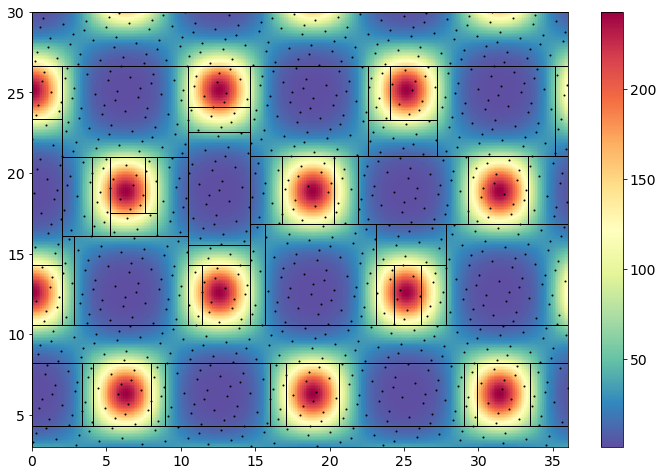

In [242]:
pc = plt.pcolormesh(xx, yy, f, cmap='Spectral_r')
plt.colorbar(pc)
plt.scatter(x[0],x[1],c='k', s=1)
plot_tree(tree, plt.gca(), color='k')

In [35]:
tree

[0, 0.46124472419964, [1, 0.6191345084024447, [0, 0.4144478614684042, [1, 0.14510393395716625, [0, 0.291255853797445, [1, 0.47135998565029724, None, None], [1, 0.4959946265702719, None, None]], [0, 0.5359746359677483, [1, 0.45458736962305857, None, None], [1, 0.32347570302573003, None, None]]], [1, 0.4883191597771086, [0, 0.4659910158566904, [1, 0.5132287709086669, None, None], [1, 0.5218480865534305, None, None]], [0, 0.5586773114018504, [1, 0.5034806861760486, None, None], [1, 0.5111007040034314, None, None]]]], [0, 0.3795439935857361, [1, 0.3845917959056395, [0, 0.49834282240139194, [1, 0.5624533789072111, None, None], [1, 0.45840450586115244, None, None]], [0, 0.5313165291109673, [1, 0.493752111962227, None, None], [1, 0.16527835074944885, None, None]]], [1, 0.2265421413450982, [0, 0.45347448201176915, [1, 0.5650783217745105, None, None], [1, 0.46745049211607637, None, None]], [0, 0.46247946165221177, [1, 0.5009423149639552, None, None], [1, 0.4643414140679797, None, None]]]]], [1,

## MCMC samples

In [14]:
mcmc_samples = np.load('samples.npy')
mcmc_weights = np.load('weights.npy')
mcmc_log_post = np.load('log_post.npy')

In [51]:
points

array([7.99987221e-01, 7.99954623e-01, 6.00414691e-01, 5.99798238e-01,
       2.49921508e+00, 2.49960798e+00, 1.29995199e-01, 1.30457002e-01,
       3.99370095e-05, 3.97321719e-05, 2.88907005e+03])

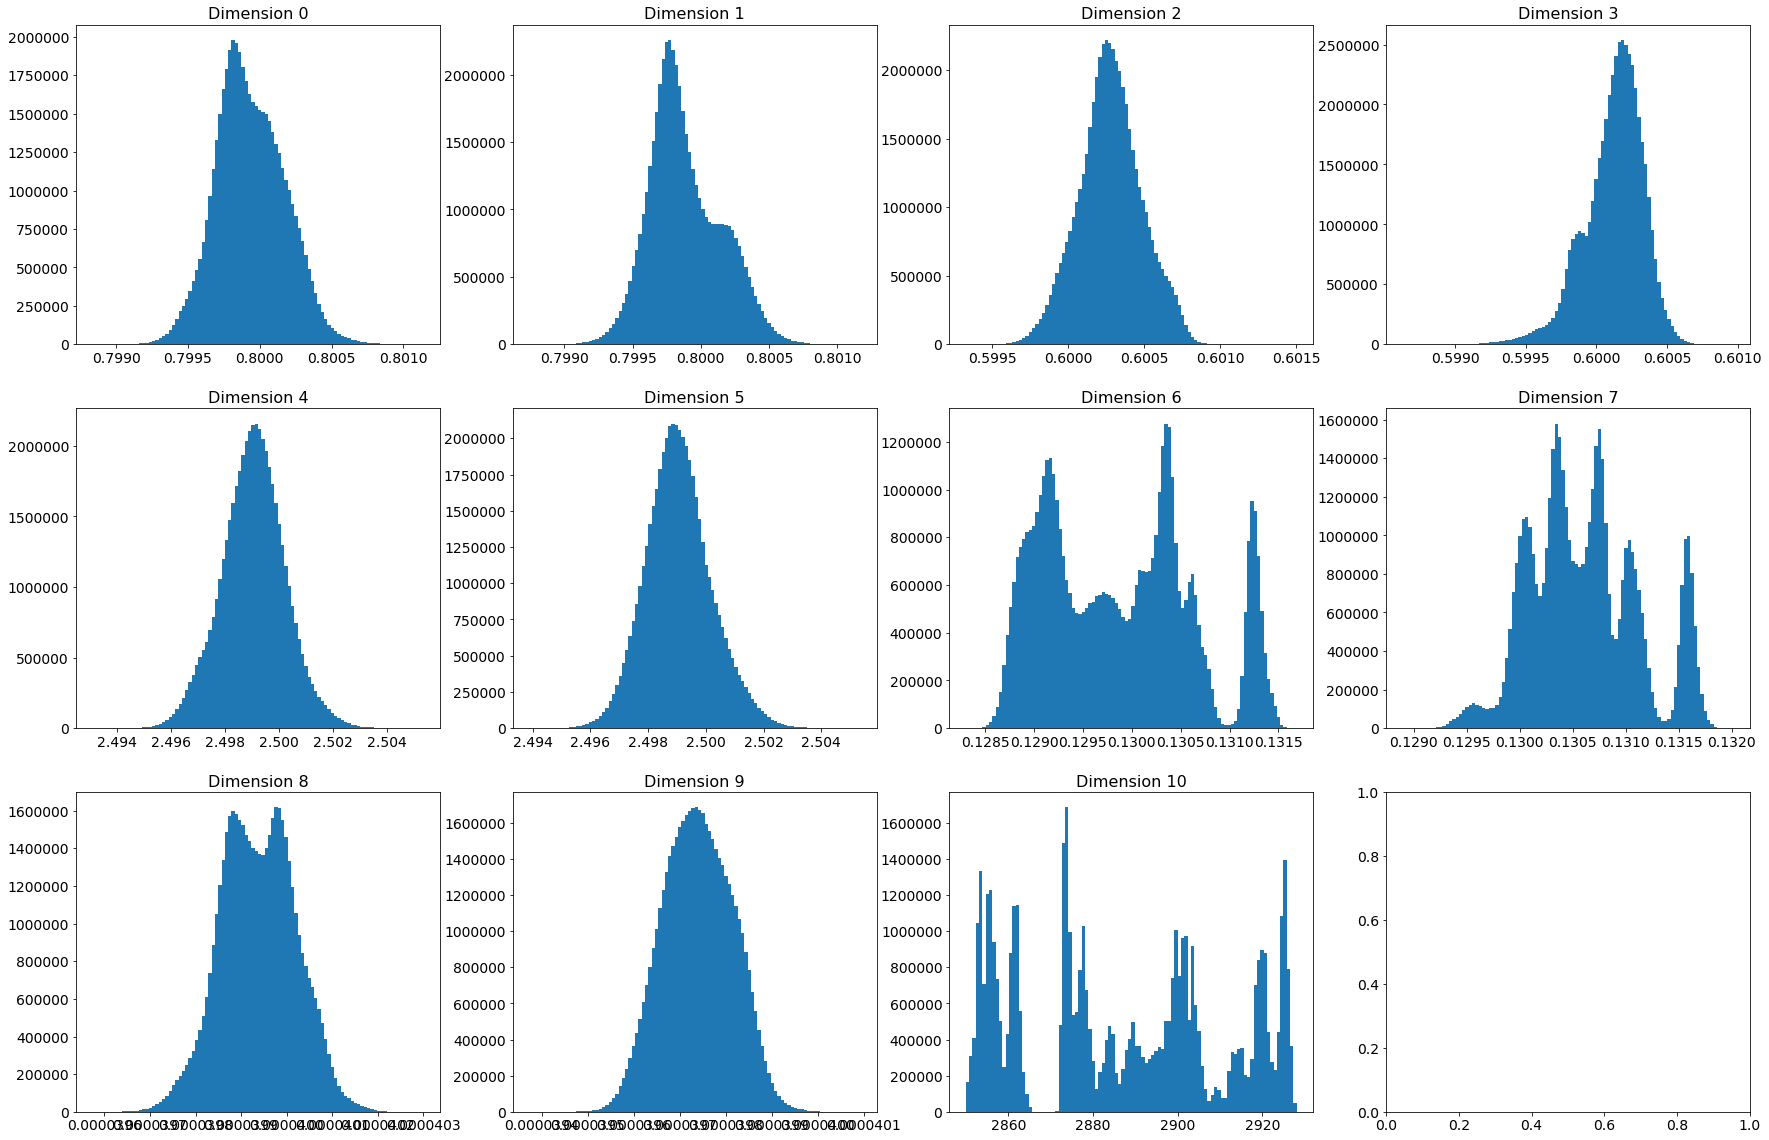

In [332]:
fig, ax = plt.subplots(3, 4, figsize=(30,20))

for i in range(11):
    ax[i//4, i%4].hist(mcmc_samples[i], bins=100, weights=mcmc_weights)
    ax[i//4, i%4].set_title(f'Dimension {i}')
    
plt.savefig('posterior.png')

In [29]:
from scipy import interpolate

In [33]:
mcmc_f = interpolate.NearestNDInterpolator(mcmc_samples.T, mcmc_log_post)

In [34]:
mcmc_f([0.5] * 11)

array([-27.72736622])

In [148]:
bounds = []
for dim in range(mcmc_samples.shape[0]):
    bounds.append([np.min(mcmc_samples[dim]), np.max(mcmc_samples[dim])])

In [149]:
bounds = np.array(bounds)

In [50]:
points = np.average(bounds, axis=1)
points

array([7.99987221e-01, 7.99954623e-01, 6.00414691e-01, 5.99798238e-01,
       2.49921508e+00, 2.49960798e+00, 1.29995199e-01, 1.30457002e-01,
       3.99370095e-05, 3.97321719e-05, 2.88907005e+03])

In [70]:
points = np.average(bounds, axis=1)
d = 6
xs = np.linspace(bounds[d,0], bounds[d,1], 101)

fs = []

for x in xs:
    points[d] = x
    fs.append(np.exp(mcmc_f(points)))

(array([1.15073507e-03, 8.07107323e-01, 2.50991187e+02, 2.81551991e+04,
        9.27435934e+04, 6.73189379e+03, 6.42074301e+02, 2.85034020e+00,
        4.55981512e-03, 1.28553601e-05]),
 array([0.79883534, 0.79906572, 0.79929609, 0.79952647, 0.79975685,
        0.79998722, 0.8002176 , 0.80044797, 0.80067835, 0.80090872,
        0.8011391 ]),
 <a list of 10 Patch objects>)

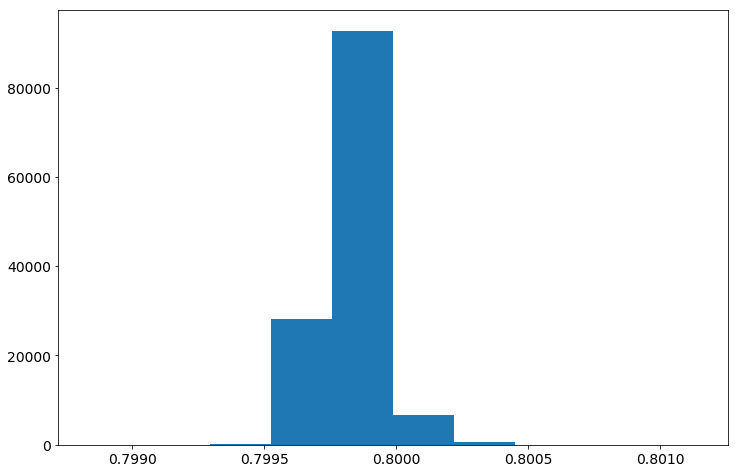

In [104]:
plt.hist(mcmc_samples[0], weights=np.exp(mcmc_log_post))

In [192]:
n_samples = 100000
#x = np.random.rand(2, n_samples)

#x = quasi_rand(mcmc_samples.shape[0], n_samples)

x = np.random.rand(mcmc_samples.shape[0], n_samples)

for dim in range(mcmc_samples.shape[0]):
    x[dim] = x[dim] * (bounds[dim][1] - bounds[dim][0]) + bounds[dim][0]
z = np.exp(mcmc_f(x.T))

(array([5.79384538e-10, 5.98282131e-07, 9.78562572e-05, 3.85677389e-03,
        1.05005255e-01, 1.19854759e+01, 9.57351320e+01, 2.48075806e+02,
        1.70477135e+02, 6.41297279e+01, 4.83200084e+01, 1.38178868e+02,
        2.49367025e+02, 2.00781694e+02, 3.44669342e+01, 1.00516981e+01,
        6.56421831e+00, 7.33831729e+00, 1.23313779e+01, 5.60479320e-01,
        1.41019684e-01, 1.23167996e-02, 1.14359833e-03, 2.62661018e-06,
        1.11033394e-04, 1.53443918e-02, 1.46288089e-02, 8.96947460e-04,
        2.97874043e-05, 5.53509414e-08]),
 array([0.12837303, 0.12848234, 0.12859166, 0.12870098, 0.12881029,
        0.12891961, 0.12902893, 0.12913824, 0.12924756, 0.12935688,
        0.12946619, 0.12957551, 0.12968482, 0.12979414, 0.12990346,
        0.13001277, 0.13012209, 0.13023141, 0.13034072, 0.13045004,
        0.13055936, 0.13066867, 0.13077799, 0.13088731, 0.13099662,
        0.13110594, 0.13121525, 0.13132457, 0.13143389, 0.1315432 ,
        0.13165252]),
 <a list of 30 Patch obj

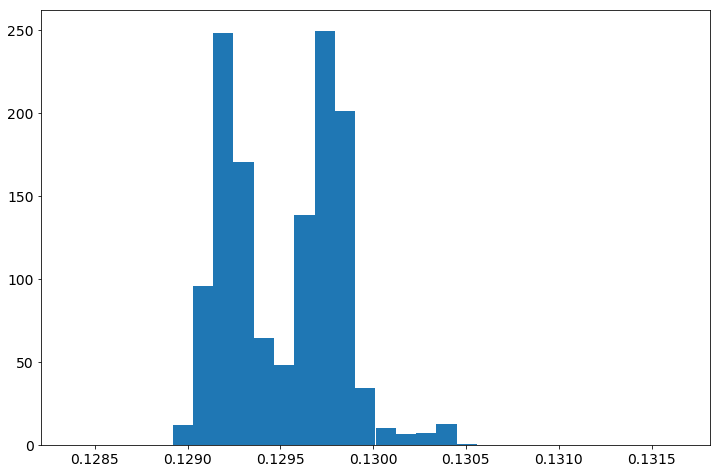

In [212]:
plt.hist(x[6], weights=z, bins=30)

In [340]:
x = mcmc_samples[:, ::1000]
z = np.exp(mcmc_log_post[::1000])
z = mcmc_weights[::1000]

In [341]:
x.shape

(11, 12000)